# Восстановление золота из руды

Задача разработать прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


## Подготовка данных

In [4]:
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn import model_selection
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
try:
    df_train = pd.read_csv('gold_recovery_train_new.csv')
    df_test = pd.read_csv('gold_recovery_test_new.csv')
    df_fullframe = pd.read_csv('gold_recovery_full_new.csv')
except:
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    df_fullframe = pd.read_csv('/datasets/gold_recovery_full_new.csv')

### Изучение данных

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate \**— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота
Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

**Нужно спрогнозировать сразу две величины:** <br/> 
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

Наименование признаков происходит по правилу `[этап].[тип_параметра].[название_параметра]`

<br/> Возможные значения для блока `[этап]`:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики <br/>

Возможные значения для блока `[тип_параметра]`:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

In [ ]:
def first_info (df):
    display(df.head(10))
    df.info()

In [ ]:
first_info(df_train)

date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   
5  2016-01-15 05:00:00                     6.482968   
6  2016-01-15 06:00:00                     6.533849   
7  2016-01-15 07:00:00                     6.130823   
8  2016-01-15 08:00:00                     5.834140   
9  2016-01-15 09:00:00                     5.687063   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   
5                    10.049416                      5.480257   
6                    10.058141                      4.569100   
7                     9.935481                      4.389813   
8                    10.071156                      4.876389   
9                     9.980404                      5.282514   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445             10.507046   
3                    42.689819              68.347543             10.422762   
4                    42.774141              66.927016             10.360302   
5                    41.633678              69.465816             10.182708   
6                    41.995316              69.300835             10.304598   
7                    42.452727              70.230976             10.443288   
8                    43.404078              69.688595             10.420140   
9                    43.235220              70.279619             10.487013   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  ...  \
0              0.895447              16.904297              2.143149  ...   
1              0.927452              16.634514              2.224930  ...   
2              0.953716              16.208849              2.257889  ...   
3              0.883763              16.532835              2.146849  ...   
4              0.792826              16.525686              2.055292  ...   
5              0.664118              16.999638              1.918586  ...   
6              0.807342              16.723575              2.058913  ...   
7              0.949346              16.689959              2.143437  ...   
8              1.065453              17.201948              2.209881  ...   
9              1.159805              17.483979              2.209593  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 14.016835   
1                                 13.992281   
2                                 14.015015   
3                                 14.036510   
4                                 14.027298   
5                                 13.938497   
6                                 14.046819   
7                                 13.974691   
8                                 13.964030   
9                                 13.989632   

   secondary_cleaner.state.floatbank4_a_level  \
0                                 -502.488007   
1                                 -505.503262   
2                                 -502.520901   
3                                 -500.857308   
4                                 -499.838632   
5                                 -500.970168   
6                                 -500.971133   
7                                 -501.819696   
8                             

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [ ]:
first_info(df_test)

date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   
5  2016-09-01 05:59:59                     168.485085   
6  2016-09-01 06:59:59                     144.133440   
7  2016-09-01 07:59:59                     133.513396   
8  2016-09-01 08:59:59                     133.735356   
9  2016-09-01 09:59:59                     126.961069   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   
5                          8.817007                         7.420000   
6                          7.924610                         7.420000   
7                          8.055252                         6.988000   
8                          7.999618                         6.935000   
9                          8.017856                         7.030000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777912   
2                        0.996043                             1398.493666   
3                        0.863514                             1399.618111   
4                        0.805575                             1401.268123   
5                        0.791191                             1402.826803   
6                        0.788838                             1398.252401   
7                        0.801871                             1401.669677   
8                        0.789329                             1402.358981   
9                        0.805298                             1400.816120   

   primary_cleaner.state.floatbank8_a_level  \
0                               -500.225577   
1                               -500.057435   
2                               -500.868360   
3                               -498.863574   
4                               -500.808305   
5                               -499.299521   
6                               -499.748672   
7                               -501.777839   
8                               -499.981597   
9                               -499.014158   

   primary_cleaner.state.floatbank8_b_air  \
0                             1399.144926   
1                             1398.055362   
2                             1398.860436   
3                             1397.440120   
4                             1398.128818   
5                             1401.511119   
6                             1393.255503   
7                             1400.754446   
8                             1400.985954   
9                             1399.975401   

   primary_cleaner.state.floatbank8_b_level  \
0                               -499.919735   
1                               -499.778182   
2                               -499.764529   
3                               -499.211024   
4                               -499.504543   
5                               -499.205357   
6                               -499.195380   
7                               -502.514024   
8                               -496.802968   
9                               -499.570552   

   primary_cleaner.state.floatbank8_c_air  ...  \
0                             1400.102998  ...   
1                             1396.151033  ...   
2                             1398.075709  ...   
3                

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [ ]:
first_info(df_fullframe)

date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   
5  2016-01-15 05:00:00                     6.482968   
6  2016-01-15 06:00:00                     6.533849   
7  2016-01-15 07:00:00                     6.130823   
8  2016-01-15 08:00:00                     5.834140   
9  2016-01-15 09:00:00                     5.687063   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   
5                    10.049416                      5.480257   
6                    10.058141                      4.569100   
7                     9.935481                      4.389813   
8                    10.071156                      4.876389   
9                     9.980404                      5.282514   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445             10.507046   
3                    42.689819              68.347543             10.422762   
4                    42.774141              66.927016             10.360302   
5                    41.633678              69.465816             10.182708   
6                    41.995316              69.300835             10.304598   
7                    42.452727              70.230976             10.443288   
8                    43.404078              69.688595             10.420140   
9                    43.235220              70.279619             10.487013   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  ...  \
0              0.895447              16.904297              2.143149  ...   
1              0.927452              16.634514              2.224930  ...   
2              0.953716              16.208849              2.257889  ...   
3              0.883763              16.532835              2.146849  ...   
4              0.792826              16.525686              2.055292  ...   
5              0.664118              16.999638              1.918586  ...   
6              0.807342              16.723575              2.058913  ...   
7              0.949346              16.689959              2.143437  ...   
8              1.065453              17.201948              2.209881  ...   
9              1.159805              17.483979              2.209593  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 14.016835   
1                                 13.992281   
2                                 14.015015   
3                                 14.036510   
4                                 14.027298   
5                                 13.938497   
6                                 14.046819   
7                                 13.974691   
8                                 13.964030   
9                                 13.989632   

   secondary_cleaner.state.floatbank4_a_level  \
0                                 -502.488007   
1                                 -505.503262   
2                                 -502.520901   
3                                 -500.857308   
4                                 -499.838632   
5                                 -500.970168   
6                                 -500.971133   
7                                 -501.819696   
8                             

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


### Признаки недоступные в тестовой выборке

Проверим каких данных нет в тестовой выборке

In [ ]:
added_data = df_train.drop(df_test.columns, axis=1)
added_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                                14149 non-null  float64


Параметры недоступные в тестовой выборке содержат информацию о параметрах продукта :
- концентрации элементов в продукте после этапа обработки 
- об отвальных хвостах. 

Так же сюда попадают 
- наши целевые признаки `final.output.recovery ` и `rougher.output.recovery `
- некоторые расчетные характеристики 

Эти данные становятся известны уже после очистки металлов, на их основе нельзя сделать предсказания, и их стоит исключить из числа признаков для обучения модели. 

Но они нужны нам сейчас чтобы проверить правильность расчета эффективности обогащения золота.

### Проверка значений recovery золота после этапа флотации

In [ ]:
#напишем функцию для расчета recovery
def recovery (c, f, t):
    recover = ((c*(f-t))/(f*(c-t)))*100
    return recover

In [ ]:
data_recover = df_train[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']]
data_recover[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']].isna().sum()

rougher.output.concentrate_au    0
rougher.input.feed_au            0
rougher.output.tail_au           0
dtype: int64

In [ ]:
# расчитываем recovery золота
au_recover = recovery(data_recover['rougher.output.concentrate_au'], 
                      data_recover['rougher.input.feed_au'], data_recover['rougher.output.tail_au'])

для проверки значений `rougher.output.recovery` сравних данные из таблицы с получеными `au_recover`. В качестве метрики качества используем MAE

In [ ]:
mae(au_recover, df_train['rougher.output.recovery'])

9.73512347450521e-15

#### Вывод

Средняя ошибка практически равна нулю, эффективность обогащения рассчитана верно

### Предобработка данных

Среди признаков есть некоторые пропущенные данные. 

Зная из условия, что <<*соседние по времени параметры часто похожи.*>> и что данные расположены в таблице по времени их фиксации, восполнить пробелы можно, используя среднее соседних с пропуском значений

In [ ]:
df_train.loc[:, df_train.columns != 'date'] = pd.concat([df_train.loc[:, df_train.columns != 'date'].ffill(), 
                                                         df_train.loc[:, df_train.columns != 'date'].bfill()]).groupby(level=0).mean()

In [ ]:
df_test.loc[:, df_test.columns != 'date']= pd.concat([df_test.loc[:, df_test.columns != 'date'].ffill(), 
                                                       df_test.loc[:, df_test.columns != 'date'].bfill()]).groupby(level=0).mean()

## Анализ данных

### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

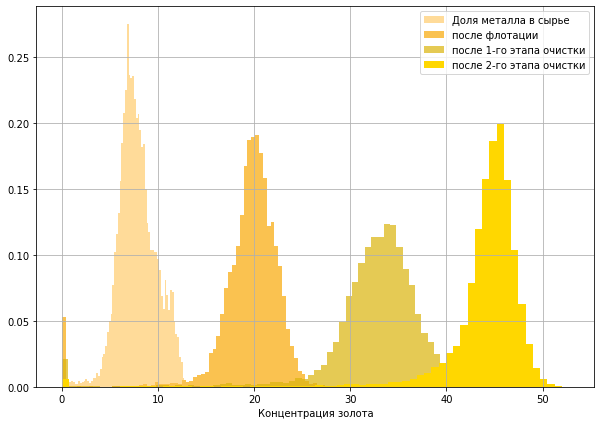

In [ ]:
plt.figure(figsize=(10, 7))
plt.hist(df_train['rougher.input.feed_au'], 
         70, density=True, color='#FFA500', alpha=0.4, label ='Доля металла в сырье')
plt.hist(df_train['rougher.output.concentrate_au'], 
         70, density=True, color='#FAC250', alpha=1, label ='после флотации')
plt.hist(df_train['primary_cleaner.output.concentrate_au'], 
         70, density=True, color='#DBB40C', alpha=0.7, label ='после 1-го этапа очистки')
plt.hist(df_train['final.output.concentrate_au'], 
         70, density=True, color='gold', alpha=1, label ='после 2-го этапа очистки')
plt.xlabel('Концентрация золота')
plt.legend(loc = 'upper right')
plt.grid(True)
plt.show()

Концентрация золота в руде по мере ее прохождения через очистку равномерно увеличивается до 50%

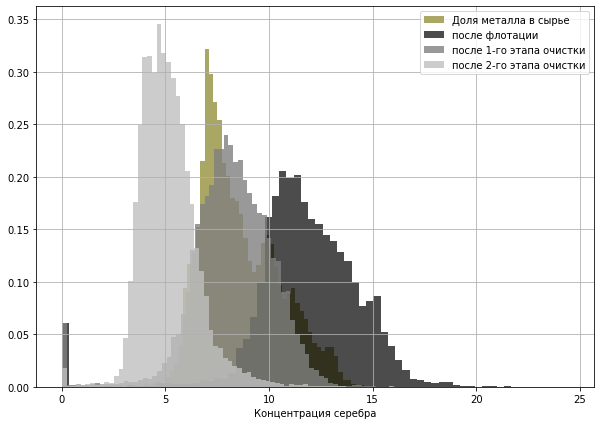

In [ ]:
plt.figure(figsize=(10, 7))
plt.hist(df_train['rougher.input.feed_ag'], 
         70, density=True, color='#AAA664', alpha=1, label ='Доля металла в сырье')
plt.hist(df_train['rougher.output.concentrate_ag'], 
         70, density=True, color='black', alpha=0.7, label ='после флотации')
plt.hist(df_train['primary_cleaner.output.concentrate_ag'], 
         70, density=True, color='grey', alpha=0.8, label ='после 1-го этапа очистки')
plt.hist(df_train['final.output.concentrate_ag'], 
         70, density=True, color='#C0C0C0', alpha=0.8, label ='после 2-го этапа очистки')
plt.xlabel('Концентрация серебра')
plt.legend(loc = 'upper right')
plt.grid(True)
plt.show()

Концентрация серебра после флотации растет, но на дальнейших этапах очистки падает и становится ниже начальной достигая 5%

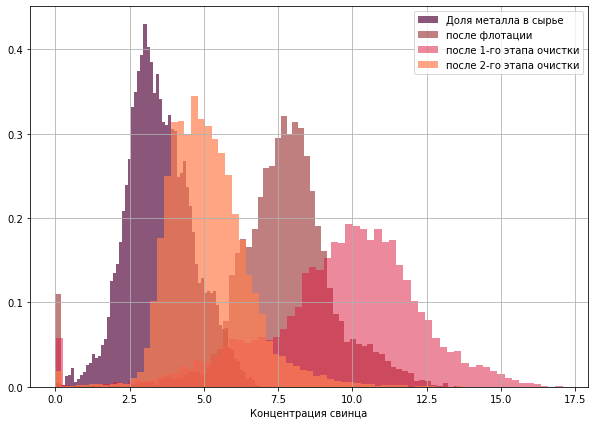

In [ ]:
plt.figure(figsize=(10, 7))
plt.hist(df_train['rougher.input.feed_pb'], 
         70, density=True, color='#580F41', alpha=0.7, label ='Доля металла в сырье')
plt.hist(df_train['rougher.output.concentrate_pb'], 
         70, density=True, color='maroon', alpha=0.5, label ='после флотации')
plt.hist(df_train['primary_cleaner.output.concentrate_pb'], 
         70, density=True, color='crimson', alpha=0.5, label ='после 1-го этапа очистки')
plt.hist(df_train['final.output.concentrate_ag'], 
         70, density=True, color='coral', alpha=0.7, label ='после 2-го этапа очистки')
plt.xlabel('Концентрация свинца')
plt.legend(loc = 'upper right')
plt.grid(True)
plt.show()

Концентрация свинца сначала растет, но после второго этапа очистки падает до 5%

Металлы отделяются и остаются в хвостах 

Это можно увидеть на примере серебра 

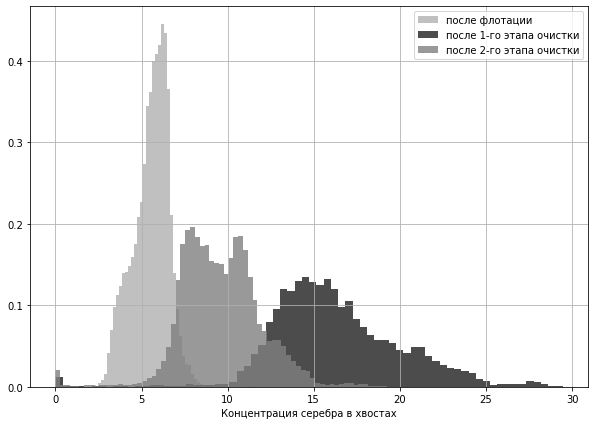

In [ ]:
plt.figure(figsize=(10, 7))
plt.hist(df_train['rougher.output.tail_ag'], 
         70, density=True, color='#C0C0C0', alpha=1, label ='после флотации')
plt.hist(df_train['primary_cleaner.output.tail_ag'], 
         70, density=True, color='black', alpha=0.7, label ='после 1-го этапа очистки')
plt.hist(df_train['final.output.tail_ag'], 
         70, density=True, color='grey', alpha=0.8, label ='после 2-го этапа очистки')

plt.xlabel('Концентрация серебра в хвостах')
plt.legend(loc = 'upper right')
plt.grid(True)
plt.show()


### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

In [ ]:
fig = make_subplots(
    rows=2, 
    cols=2,
    subplot_titles=('Размер гранул до флотации train','Размер гранул до флотации test', 
                   'Размер гранул до первичной обработки train','Размер гранул до первичной обработки test')
)
fig.add_trace(go.Histogram(x=df_train['rougher.input.feed_size'],
                           histnorm = 'density', name='число гранул'),  row=1, col=1)
fig.add_trace(go.Histogram(x=df_test['rougher.input.feed_size'],
                           histnorm = 'density', name='число гранул'), row=1, col=2)
fig.add_trace(go.Histogram(x=df_train['primary_cleaner.input.feed_size'],
                           histnorm = 'density', name='число гранул'), row=2, col=1)
fig.add_trace(go.Histogram(x=df_test['primary_cleaner.input.feed_size'],
                           histnorm = 'density', name='число гранул'), row=2, col=2)

fig.update_layout(height=700, width=1000, title_text="Сравнение размеров гранул в тренировочной и тестовой выборке",
                  xaxis1_range=[0,150], xaxis2_range=[0,150], xaxis3_range=[5,10], xaxis4_range=[5,10],
                  margin=dict(l=0, r=0, t=100, b=10))
fig.show()
 

Можно считать, что распределения размеров гранул в выборках не сильно отличаются:
- имеют примерно одинаковые границы (хотя в них присутствуют выбросы)
- максимумы находятся в близких значениях

Оценка модели будет правильной.

###  Сравнение суммарной концентрации всех веществ в сырье, в черновом и финальном концентратах. 

Посчитаем суммарную концентрацию веществ на разных этапах

In [ ]:
df_conсentrate= pd.DataFrame()

df_conсentrate['input'] = (df_train['rougher.input.feed_ag']
                           +df_train['rougher.input.feed_pb']
                           +df_train['rougher.input.feed_au']
                           +df_train['rougher.input.feed_sol'])

df_conсentrate['rougher'] = (df_train['rougher.output.concentrate_ag']
                             +df_train['rougher.output.concentrate_pb']
                             +df_train['rougher.output.concentrate_au']
                             +df_train['rougher.output.concentrate_sol'])

df_conсentrate['primary_cleaner'] = (df_train['primary_cleaner.output.concentrate_ag']
                                     +df_train['primary_cleaner.output.concentrate_pb']
                                     +df_train['primary_cleaner.output.concentrate_au']
                                     +df_train['primary_cleaner.output.concentrate_pb']
                                     +df_train['primary_cleaner.output.concentrate_sol'])

df_conсentrate['final'] = (df_train['final.output.concentrate_ag']
                           +df_train['final.output.concentrate_pb']
                           +df_train['final.output.concentrate_au']
                           +df_train['final.output.concentrate_sol'])

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_conсentrate['input'], name='Концентрация металлов в сырье'))
fig.add_trace(go.Histogram(x=df_conсentrate['rougher'], name='Концентрация металлов после флотации'))
fig.add_trace(go.Histogram(x=df_conсentrate['primary_cleaner'], name='Концентрация металлов после 1-го этапа очистки'))
fig.add_trace(go.Histogram(x=df_conсentrate['final'], name='Финальная концентрация металлов'))

fig.update_layout(height=700, width=1000, title_text="Суммарная концентрация веществ на разных этапах", 
                  margin=dict(l=0, r=0, t=100, b=10))  
fig.show()
 

По гистограммам заметно как увеличивается концентрация металлов после каждого этапа очистки.

На графике присутствуют выбросы с нулевыми значениями. Такие наблюдения являются аномалиями и их нужно удалить из данных.

In [ ]:
df_anomaly = (df_conсentrate[df_conсentrate['input']<=30]
                 + df_conсentrate[df_conсentrate['rougher']<=30]
                 + df_conсentrate[df_conсentrate['primary_cleaner']<=30]
                 + df_conсentrate[df_conсentrate['final']<=30])

try:
    df_train = df_train.drop(df_anomaly.index)
    df_train.shape
except:
    display(df_train.shape)

## Модель

### Функция для вычисления итоговой sMAPE.

In [ ]:
def sMAPE (target, predict):
    n=len(target)
    smape = (((np.abs(target-predict)/((np.abs(target)+np.abs(predict))/2))*100).sum())/n 
    return smape

### Подбор параметров модели на тренировочной выборке

#### Подготавливаем признаки

Убираем из тренеровочной выборки данные о концентрации элементов в продукте, отвальных хвостах и другую информацию, которая может привести к утечке целевого признака

В число признаков входят данные о реагентах и параметрах этапов

In [ ]:
columns_for_model = df_test.columns
# колонки с целевым признаком нам нужны
columns_for_model = np.append(columns_for_model, ['rougher.output.recovery', 'final.output.recovery'])
columns_for_model.shape  # вместо 87 уже 55 колонок

(55,)

In [ ]:
df_train = df_train[columns_for_model]

Теперь в `df_train` есть только нужные производственные признаки, дата их фиксации и целевые признаки


In [ ]:
np.random.seed(12345)
scaler = StandardScaler()

In [ ]:
features=df_train.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis=1) #убираем из списка признаков целевой признак
target_1 = df_train['rougher.output.recovery']
target_2 = df_train['final.output.recovery']

Формула для подбора параметров моделт RandomForest

In [ ]:
def make_model_rf (features, target):
    np.random.seed(12345)
    best_model = None
    best_estimation = 0
    
    classifier = RandomForestRegressor(n_jobs=-1)
    param_grid = {
        "n_estimators": np.arange(100, 1000,100),
        "max_depth" : [4, 7, 10]
    }

    model = model_selection.RandomizedSearchCV(
        estimator =classifier,
        param_distributions= param_grid,
        n_iter=10,
        scoring = make_scorer(sMAPE, greater_is_better=False),
        verbose =10,
        n_jobs = -1,
        cv = 5
    )
    model.fit(features,target)
    
    print (model.best_score_)
    print(model.best_estimator_.get_params())
    
    return model.best_score_

Формула для подбора параметров моделт DesicionTree

In [ ]:
def make_model_dt (features, target): 
    np.random.seed(12345)
    best_model = None
    best_estimation = 0
    
    classifier = RandomForestRegressor(n_jobs=-1)
    param_grid = {
        "min_samples_split": np.arange(2, 20, 2),
        "max_depth" : np.arange(1, 20, 2)
    }

    model = model_selection.RandomizedSearchCV(
        estimator =classifier,
        param_distributions= param_grid,
        n_iter=10,
        scoring = make_scorer(sMAPE, greater_is_better=False),
        verbose =10,
        n_jobs = -1,
        cv = 5
    )
    model.fit(features,target)
    
    print (model.best_score_)
    print(model.best_estimator_.get_params())
    
    return model.best_score_

#### Перебираем параметры

Для подбора параметров модели достаточно меньшей выборки, чем есть в df_train, поэтому выделим ее с помощью `train_test_split`.
Так же масштабируем признаки.

Признаки из `target` будем предсказывать по отдельности. Тогда мы сможем передать в параметр оценки качества модели `scoring`  функцию sMAPE 

In [ ]:
scaler.fit(features)
features_s= scaler.transform(features)
pd.options.mode.chained_assignment = None

**RandomForest**

In [ ]:
smape_rougher_rf =  make_model_rf(features_s, target_1)
smape_rougher_rf

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=10, n_estimators=600.............................
[CV 1/5; 1/10] END ...........max_depth=10, n_estimators=600; total time= 2.7min
[CV 2/5; 1/10] START max_depth=10, n_estimators=600.............................
[CV 2/5; 1/10] END ...........max_depth=10, n_estimators=600; total time= 2.7min
[CV 3/5; 1/10] START max_depth=10, n_estimators=600.............................
[CV 3/5; 1/10] END ...........max_depth=10, n_estimators=600; total time= 2.7min
[CV 4/5; 1/10] START max_depth=10, n_estimators=600.............................
[CV 4/5; 1/10] END ...........max_depth=10, n_estimators=600; total time= 2.6min
[CV 5/5; 1/10] START max_depth=10, n_estimators=600.............................
[CV 5/5; 1/10] END ...........max_depth=10, n_estimators=600; total time= 2.7min
[CV 1/5; 2/10] START max_depth=4, n_estimators=900..............................
[CV 1/5; 2/10] END ............max_depth=4, n_es

-6.109458931270728

**DesicionTree**

In [ ]:
smape_rougher_dt =  make_model_dt(features_s, target_1)
smape_rougher_dt

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=1, min_samples_split=10..........................
[CV 1/5; 1/10] END ........max_depth=1, min_samples_split=10; total time=   3.7s
[CV 2/5; 1/10] START max_depth=1, min_samples_split=10..........................
[CV 2/5; 1/10] END ........max_depth=1, min_samples_split=10; total time=   3.7s
[CV 3/5; 1/10] START max_depth=1, min_samples_split=10..........................
[CV 3/5; 1/10] END ........max_depth=1, min_samples_split=10; total time=   3.7s
[CV 4/5; 1/10] START max_depth=1, min_samples_split=10..........................
[CV 4/5; 1/10] END ........max_depth=1, min_samples_split=10; total time=   3.7s
[CV 5/5; 1/10] START max_depth=1, min_samples_split=10..........................
[CV 5/5; 1/10] END ........max_depth=1, min_samples_split=10; total time=   3.7s
[CV 1/5; 2/10] START max_depth=3, min_samples_split=2...........................
[CV 1/5; 2/10] END .........max_depth=3, min_sam

-6.137239515328266

**LinearRegression**


В линейную регрессию передаем всю выборку

In [ ]:
features_s = scaler.transform(features)

model_lr = LinearRegression(n_jobs=-1)
scores = []
scores = cross_val_score(model_lr,features_s, target_1, cv=5, scoring=make_scorer(sMAPE, greater_is_better=False))
final_score_lr = scores.mean()

final_score_lr

-7.179164974611746

#### Перебираем параметры 2

Так же подбираем модель на втором целевом признаке `'final.output.recovery'`

**RandomForest**

In [ ]:
smape_final_rf =  make_model_rf(features_s, target_2)
smape_final_rf

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=10, n_estimators=600.............................
[CV 1/5; 1/10] END ...........max_depth=10, n_estimators=600; total time= 2.9min
[CV 2/5; 1/10] START max_depth=10, n_estimators=600.............................
[CV 2/5; 1/10] END ...........max_depth=10, n_estimators=600; total time= 3.0min
[CV 3/5; 1/10] START max_depth=10, n_estimators=600.............................
[CV 3/5; 1/10] END ...........max_depth=10, n_estimators=600; total time= 2.9min
[CV 4/5; 1/10] START max_depth=10, n_estimators=600.............................
[CV 4/5; 1/10] END ...........max_depth=10, n_estimators=600; total time= 2.9min
[CV 5/5; 1/10] START max_depth=10, n_estimators=600.............................
[CV 5/5; 1/10] END ...........max_depth=10, n_estimators=600; total time= 2.9min
[CV 1/5; 2/10] START max_depth=4, n_estimators=900..............................
[CV 1/5; 2/10] END ............max_depth=4, n_es

-8.65395476632551

**DesicionTree**

In [ ]:
smape_rougher_dt = make_model_dt(features_s, target_2)
smape_rougher_dt

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=1, min_samples_split=10..........................
[CV 1/5; 1/10] END ........max_depth=1, min_samples_split=10; total time=   3.8s
[CV 2/5; 1/10] START max_depth=1, min_samples_split=10..........................
[CV 2/5; 1/10] END ........max_depth=1, min_samples_split=10; total time=   3.8s
[CV 3/5; 1/10] START max_depth=1, min_samples_split=10..........................
[CV 3/5; 1/10] END ........max_depth=1, min_samples_split=10; total time=   3.9s
[CV 4/5; 1/10] START max_depth=1, min_samples_split=10..........................
[CV 4/5; 1/10] END ........max_depth=1, min_samples_split=10; total time=   3.8s
[CV 5/5; 1/10] START max_depth=1, min_samples_split=10..........................
[CV 5/5; 1/10] END ........max_depth=1, min_samples_split=10; total time=   3.8s
[CV 1/5; 2/10] START max_depth=3, min_samples_split=2...........................
[CV 1/5; 2/10] END .........max_depth=3, min_sam

-8.743642740273547

**LinearRegression**


В линейную регрессию передаем всю выборку

In [ ]:
model_lr = LinearRegression(n_jobs=-1)
scores = []
scores = cross_val_score(model_lr, features_s, target_2, cv=5, scoring=make_scorer(sMAPE, greater_is_better=False))
final_score_lr = scores.mean()

final_score_lr

-10.759460814552872

#### Выводы

Модели лучше обучились для предсказания `'final.output.recovery'`. Значения метрики sMAPE примерно одинаковые у RandomForest и DesicionTree. Интерпретируя результат, полученные модели в среднем ошибаются на 6%

## Предсказания на тестовой выборке

### Подготавливаем признаки

Для проведения теста признаки мы берем из тестовой выборки. Целевой признак для расчета sMAPE и оценки качества из полного датафрейма `df_fullframe`. Признаки предсказываем по отдельности.

Данные для обучения:
- масштабированные признаки = features_s
- целевой признак `rougher.output.recovery` = target_1
- целевой признак `final.output.recovery` = target_2

Тестовый набор

- признаки = features_test
- целевой признак `rougher.output.recovery` = target_r
- целевой признак `final.output.recovery` = target_f

In [ ]:
target_test = df_test.merge(df_fullframe[['date','rougher.output.recovery', 'final.output.recovery']], on='date')

In [ ]:
features_test = df_test.drop(['date'], axis=1)  # признаки
features_t= scaler.transform(features_test)

target_r = target_test['rougher.output.recovery']  # целевой признак
target_f = target_test['final.output.recovery']  # целевой признак

### Обучаем модели для двух признаков

In [ ]:
model_rougher = RandomForestRegressor(max_depth= 12, max_features = 'auto',
                                    min_samples_leaf= 1,  n_estimators = 200, n_jobs=-1)
model_rougher.fit(features_s, target_1)
rougher_predict = model_rougher.predict(features_t)

In [ ]:
model_final =   RandomForestRegressor(max_depth= 4, max_features = 'auto',
                                    min_samples_leaf= 1, n_estimators = 400, n_jobs=-1)
model_final.fit(features_s, target_2)
final_predict = model_final.predict(features_t)

### Считаем sMAPE

In [ ]:
smape_rougher = sMAPE(target_r, rougher_predict)
smape_rougher

7.999214709469303

In [ ]:
smape_final = sMAPE(target_f, final_predict)
smape_final

9.837482792603426

### Считаем итоговое sMAPE по формуле

In [ ]:
total_smape=(0.25*smape_rougher)+(0.75*smape_final)
total_smape

9.377915771819897

In [ ]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(features_s, target_2)
dummy_predict = dummy_model.predict(features_t)
smape_dummy = sMAPE(target_f, dummy_predict)
smape_dummy

10.05626138891409

### Вывод

- В ходе иследования были созданы модели для предсказания эффективность обогащения золота из руды.
- Итоговое значение sMAPE модели равно 9.37, значит модель в среднем ошибается на 9 %.
- sMAPE полученной модели отличается от результатов константной модели (выдает всегда среднее значение) только на 1%



- Были иследованы изменения концентрации металлов на разных этапах очистки.<br/>
  После второго этапа концентрация золота увеличивается до 42-48%, в то время как концентрация серебра и свинца падает примерно   до 3-7%.
- В ходе восстановления золота из руды, общее содержание металлов возрастает до 55-62%.